In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
import ast
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

# 1


## 1.1

-	It is shown that when we trade extreme winners and losers, we will get significant excess returns. 
-	Also, if we trade more broadly deciles, it would have a large transaction fee. 
Yes. Empirical data shows that we can get higher returns when we trade a single decile top and bottom than 3 deciles. 

## 1.2

- It has negative exposure to market volatility.
- $\beta^{Up}$ is negative as 0 .78 so LTCM appears short the call-like factor.
- $\beta^{Down}$ is positive as 1.29 so LTCM appears long the put-like factor.
- So it must long the downside more than short the upside more than. 

## 1.3

-	The mean-variance solution when we have a full covariance matrix is very sensitive to means and covariances. If two securities are quite correlated, the MV solution will take a long position in the security with the higher mean, and a short position in the security with the lower mean. This can result in much more variation in the magnitude of portfolio weights.
-	We can add some explicit constraints, also we can use LASSO and Ridge regression to make the covariance matrix more diagonal-like, in order to solve the problem when we invert it. 

## 1.4

-	TS regression: 264 * (factor number+1) (if add constant). Run 40 TS regressions. 
-	40*(factor number +1) (if add constant). Run 1 CS regression.


## 1.5

-	GMO is, in a macro sense, a value investor. They invest in asset classes with low prices per cash flow. This means that they are buying into depressed assets and missing out on assets with large run-ups in price. The case mentions that as GMO missed the bull market of the late 1990s, they experienced large withdrawals before ultimately being proven right in the crash of 2000-2001.
-	GMO’s contrarian positions put it in some funding risk. If they deviate too much from other funds during strong performance, clients may want to withdraw money. (Of course, if GMO can survive, they can show strong performance when other funds are not doing well.) This is exactly what happened in the late 1990’s. This same effect impacts managers, who may be rated as missing strong run-ups even if their contrarian strategy will pay off in the long run.

## 1.6
- 1. They use classified 11 assets group instead of directly investing in 400 assets. 
- 2. They add constraints to their portfolios to avoid extreme positions. 
- Yes. It is much easier to implement from a numerical view. It is easier to calculate the covariance matrix, however, the constraint may add some difficulties when solving the optimization.


## 1.7 
- If stocks have log iid returns with normal distribution, there long term Sharpe ratio would be multiplied by $\sqrt T$ compared to short term(t=1) Sharpe ratio due to the mean return is scale by $T$ while vol is only scaled by $\sqrt T$. 

## 1.8

- If we hold the assumption that the forward FX rate is the best guess for the future spot rate, then CIP implys UIP. 
- However, UIP says nothing about CIP. CIP is always true due to the Law of One Price, however UIP is only a theory, and in practise it is not always the case. 

## 1.9
- The historical returns do not show the population mean return. 
- Due to survivor bias and backfill bias and incubator bias, we cannot extimate the population mean with certainty. 

## 1.10

- By regressing the returns on SPY returns, with a constant, report the expanding $\beta_t$ as the optimal hedging ratio. 
- Short $\beta_t$ units of SPY. Rebalance your position dynamically. 

# Functions

In [5]:
def cal_risk(df, quant=0.05):
    result = pd.DataFrame()
    # you don't neet to annualize higher moments
    var_name = f'VaR ({quant})'
    cvar_name = f'CVaR ({quant})'
    # result['skewness'] = df.skew()
    # result['kurtosis'] = df.kurtosis()
    result[var_name] = df.quantile(quant)
    result[cvar_name] = df[df < df.quantile(quant)].mean()
    return result

In [23]:
def get_capm_matrics(targets, regressors, add_constant=True, annualize_factor=12):

    result = pd.DataFrame(index=targets.columns)
    resid_matrix = pd.DataFrame(columns=targets.columns)
    t_p_value = pd.DataFrame(index=targets.columns)

    if add_constant:
        X = sm.add_constant(regressors)
    else:
        X = regressors.copy()
    for column in targets.columns:
        y = targets[[column]]
        model = sm.OLS(y, X, missing='drop').fit()
        if add_constant:
            result.loc[column, "alpha"] = model.params['const'] * \
                annualize_factor
        result.loc[column, regressors.columns] = model.params[regressors.columns]

        result.loc[column, "R-squared"] = model.rsquared

        resid_matrix[column] = model.resid
        if add_constant:
            t_p_value.loc[column, "t-value"] = model.tvalues['const']
            t_p_value.loc[column, "p-value"] = model.pvalues['const']

    return result, resid_matrix, t_p_value



In [57]:
def summary_stat(df, annual_factor):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe Ratio"] = result["mean"]/result["volatility"]

    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    result['Max Drawdown'] = drawdown.min()

    return result

In [72]:
def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]

        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y, lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = linear_model.LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col, 'Treynor Ratio'] = (
                y.mean() / model.coef_) * annualization

        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (
                model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg


In [79]:
def get_each_reg(targets, regressors, annualize_factor=12):

    result = pd.DataFrame(index=targets.columns)

    for i in range(targets.shape[1]):
        X = regressors.iloc[:, i]
        X = sm.add_constant(X)
        y = targets.iloc[:, i]
        column = targets.columns[i]
        model = sm.OLS(y, X, missing='drop').fit()
        result.loc[column, "alpha"] = model.params['const'] * annualize_factor
        result.loc[column, "beta"] = model.params[1]
        result.loc[column, "R-squared"] = model.rsquared

    return result.T

In [91]:
def oos_reg(y, X, start, add_constant=True):
    # need to use python 3.8
    if add_constant:
        X = sm.add_constant(X)
    model = RollingOLS(
        y, X, window=X.shape[0], min_nobs=start-1, expanding=True).fit()
    params = model.params.shift().iloc[start:]

    rolling_pre = (model.params.shift() * X).sum(axis=1)
    zero_pre = y.expanding(start).mean().shift()

    predict_all = pd.concat([y, rolling_pre, zero_pre], axis=1).iloc[start:]
    predict_all.columns = ["Real", "Forecast", "Zero predict"]
    predict_err = np.square(
        predict_all["Real"] - predict_all["Forecast"]).sum()
    zero_pre_err = np.square(
        predict_all["Real"] - predict_all["Zero predict"]).sum()
    # print(predict_err, zero_pre_err)
    r_squared = 1 - predict_err/zero_pre_err
    return params, predict_all, r_squared

# 2 Value at Risk
## 2.1 Calculate the 5th percentile VaR and CVaR for GLD as of the end of the sample using the empirical CDF approach over the full sample of data.

In [2]:
ret = pd.read_excel("../data/final_exam_data.xlsx", sheet_name=2, index_col=0)
ret.head()

,GLD,Tbill rate,Tbill change
Date,,,
2009-04-19,-0.0126,0.130,-0.045
2009-04-26,0.0528,0.095,-0.035
2009-05-03,-0.0309,0.145,0.050
2009-05-10,0.0348,0.165,0.020
2009-05-17,0.0174,0.155,-0.010


In [4]:
cal_risk(ret[["GLD"]])

,VaR (0.05),CVaR (0.05)
GLD,-0.0333,-0.0471


## 2.2 Calculate the 5th percentile VAR for GLD as of the end of the sample using the normal approximation, (assuming mean is zero as usual.) 

In [147]:
z_phi = stats.norm.ppf(0.05)
gold_ret = ret[["GLD"]]
vol = np.sqrt((gold_ret**2).mean())
VaR = z_phi * vol
print("Full-sample volatility: " + str(VaR[0]))

Full-sample volatility: -0.03476093655812897


In [149]:
gold_ret = ret[["GLD"]]
rolling_vol = np.sqrt((gold_ret**2).shift(1).rolling(window=150).mean())
historical_var = rolling_vol.dropna() * z_phi
historical_var.columns = ["historical var"]
historical_var

,historical var
Date,
2012-03-04,-0.0399
2012-03-11,-0.0401
2012-03-18,-0.0395
2012-03-25,-0.0395
2012-04-01,-0.0392
...,...
2022-11-06,-0.0374
2022-11-13,-0.0375
2022-11-20,-0.0380


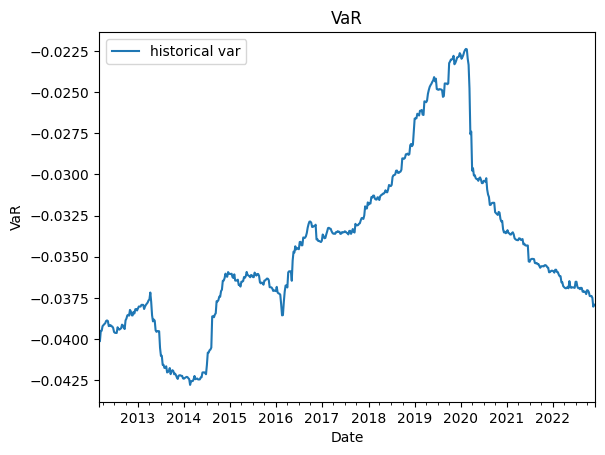

In [150]:
historical_var.plot()

plt.title('VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

## 2.3 In our analysis in the course, which of the methods above did we find did best?

- The normal approximation one is better. Becuase this method's hit rate of the VaR is closer to the precentile rate. 

# 3 Pricing Model (25 pts)
## 3.1 (10pts) Estimate the time-series test of the pricing model.

In [19]:
future_ret = pd.read_excel("../data/final_exam_data.xlsx", sheet_name=1, index_col=0)
factors = pd.read_excel(
    "../data/final_exam_data.xlsx", sheet_name=0, index_col=0)
factors.head()

,MKT,UMD
Date,,
2000-01-31,-0.0474,0.0192
2000-02-29,0.0245,0.1820
2000-03-31,0.0520,-0.0683
2000-04-30,-0.0640,-0.0839
2000-05-31,-0.0442,-0.0898


In [24]:
result, resid_matrix, t_p_value = get_capm_matrics(
    future_ret, factors, add_constant=True, annualize_factor=12)
result

,alpha,MKT,UMD,R-squared
NG1,0.1120,0.3541,0.3812,0.0173
KC1,0.0232,0.3151,-0.0275,0.0259
CC1,0.0708,0.2073,-0.0358,0.0120
LB1,0.0645,0.9421,-0.0048,0.1368
CT1,0.0249,0.5042,-0.1786,0.0990
SB1,0.0931,0.0580,-0.3192,0.0327
LC1,0.0154,0.1831,0.0661,0.0200
W1,0.0545,0.2989,0.0224,0.0213
S1,0.0425,0.3995,0.0273,0.0529
C1,0.0609,0.3404,0.0620,0.0282


In [27]:
print("MAE: " + str(np.abs(result["alpha"]).mean()))

MAE: 0.05891893228048153


In [26]:
print("mean of r-squared:" + str(result["R-squared"].mean()))

mean of r-squared:0.05874717942946507


### 3.1(b) If the pricing model worked perfectly, what would these statistics be?

- Alpha should be zero.(small)
- MAE should be zero. 
- Time-series test says nothing about r-squared

## 3.2 2. (10pts) Estimate the cross-sectional test of the pricing model. Include an intercept in the cross- sectional regression.

In [39]:
y = future_ret.mean(axis=0).to_frame("mean return")

In [31]:
cs_result, cs_resid_matrix, t_p_value = get_capm_matrics(
    y, result[["MKT", "UMD"]], add_constant=True, annualize_factor=12)
cs_result

,alpha,MKT,UMD,R-squared
mean return,0.0611,0.0052,0.0061,0.3914


In [38]:
print("Annnualized mean-absolute error:" + str(np.abs(cs_resid_matrix).mean()[0] * 12))

Annnualized mean-absolute error:0.018001671556518994


### 3.2(b) If the pricing model worked perfectly, what would these statistics be?
- Alpha should be zero. 
- mean-absolute error should be zero.
- R-squared should be 1. 

## 3.3 (5pts) Compare the factor premia across the cross-sectional and time-series estimations.
- MKT ts premia > cs premia(very close)
- UMD ts premia < cs premia

In [45]:
res = factors.mean().to_frame("ts premia")
res["cs premia"] = cs_result.values.T[1:3,]
res

,ts premia,cs premia
MKT,0.0059,0.0052
UMD,0.0015,0.0061


# 4 Forecasting (50pts)
## 4.1

In [154]:
ret = pd.read_excel("../data/final_exam_data.xlsx", sheet_name=2, index_col=0)
ret

,GLD,Tbill rate,Tbill change
Date,,,
2009-04-19,-0.0126,0.130,-0.045
2009-04-26,0.0528,0.095,-0.035
2009-05-03,-0.0309,0.145,0.050
2009-05-10,0.0348,0.165,0.020
2009-05-17,0.0174,0.155,-0.010
...,...,...,...
2022-11-06,0.0216,4.013,0.043
2022-11-13,0.0517,4.063,0.050
2022-11-20,-0.0108,4.135,0.072


In [155]:
X = ret[["Tbill rate", "Tbill change"]].shift()
X = sm.add_constant(X)
y = ret[["GLD"]]

static_model = sm.OLS(y, X, missing='drop').fit()
print("No need to annualize these stats.")
static_model.params.to_frame("GLD")

No need to annualize these stats.


,GLD
const,0.0010
Tbill rate,0.0003
Tbill change,0.0005


In [156]:
print("r-squared:" + str(static_model.rsquared))

r-squared:0.00010651991509946779


## 4.2

In [157]:
predict = static_model.predict(X)
weight = (predict*80 + 0.2).to_frame('GLD')
portfolio_ret = weight * y
portfolio_ret.columns = ["portfolio ret"]
portfolio_ret.tail()

,portfolio ret
Date,
2022-11-06,0.0078
2022-11-13,0.0187
2022-11-20,-0.0039
2022-11-27,0.0010
2022-12-04,-0.0011


## 4.3 (3pts) For both rx and rGLD, report the following univariate stats (annualized).

In [158]:
portfolio_ret["gold ret"] = y
portfolio_ret = portfolio_ret.dropna()
portfolio_ret

,portfolio ret,gold ret
Date,,
2009-04-26,0.0148,0.0528
2009-05-03,-0.0086,-0.0309
2009-05-10,0.0099,0.0348
2009-05-17,0.0049,0.0174
2009-05-24,0.0080,0.0284
...,...,...
2022-11-06,0.0078,0.0216
2022-11-13,0.0187,0.0517
2022-11-20,-0.0039,-0.0108


In [159]:
summary_stat(portfolio_ret, 12)

,mean,volatility,Sharpe Ratio,Max Drawdown
portfolio ret,0.0040,0.0209,0.1911,-0.1426
gold ret,0.0136,0.0732,0.1859,-0.4474


## 4.4  Run a Linear Factor Decomposition of rx on rGLD and report the following (annualized)

In [160]:
get_ols_metrics(portfolio_ret[["gold ret"]], portfolio_ret[["portfolio ret"]], annualization=12)

,alpha,gold ret,r-squared,Treynor Ratio,Info Ratio
portfolio ret,0.0001,0.2856,0.9971,0.014,0.1026


## 4.5 Suppose we were going to forecast GLD using just one of our two signals. Which of the signals would likely lead to a result where the long-term forecast compounds the effect over long horizons, as we saw for forecasting SPY using dividend-price ratios? Explains

- "Tbill rate" signal. It has higher serial correlation than "Tbill change" signal. So it may have better predict in the long run due to the cumulative effect. 

## 4.6 (5pts) Let’s consider the out-of-sample performance of the strategy.

In [92]:
begin = X[:"2016"].shape[0]
params, predict_all, r_squared = oos_reg(y, X, begin, True)

In [93]:
predict_all.head()

,Real,Forecast,Zero predict
Date,,,
2017-01-01,0.0156,0.0043,0.0008
2017-01-08,0.0195,0.0083,0.0009
2017-01-15,0.0220,0.0045,0.0009
2017-01-22,0.0074,0.0069,0.0009
2017-01-29,-0.0136,0.0110,0.0010


In [94]:
predict_all.tail()

,Real,Forecast,Zero predict
Date,,,
2022-11-06,0.0216,0.0006,0.0010
2022-11-13,0.0517,0.0011,0.0011
2022-11-20,-0.0108,0.0025,0.0011
2022-11-27,0.0026,0.0022,0.0011
2022-12-04,-0.0030,0.0022,0.0011


## 4.7 Report the out-of-sample R2, relative to a baseline forecast which is simply the mean of GLD up to the point the forecast is made.

In [95]:
print("oos r-squared:" + str(r_squared))

oos r-squared:-0.14488422352127506


## 4.8 

In [103]:
predict_all.corr()

,Real,Forecast,Zero predict
Real,1.0000,-0.1952,-0.1049
Forecast,-0.1952,1.0000,-0.0667
Zero predict,-0.1049,-0.0667,1.0000


In [107]:
weight = predict_all * 80 + 0.2
weight

,Real,Forecast,Zero predict
Date,,,
2017-01-01,1.4453,0.5458,0.2652
2017-01-08,1.7619,0.8638,0.2681
2017-01-15,1.9611,0.5631,0.2718
2017-01-22,0.7884,0.7502,0.2759
2017-01-29,-0.8847,1.0791,0.2772
...,...,...,...
2022-11-06,1.9289,0.2446,0.2828
2022-11-13,4.3363,0.2890,0.2851
2022-11-20,-0.6605,0.4017,0.2908


In [110]:
y_new = y
y_new["Zero predict"] = y
y_new.columns = ["Forecast", "Zero predict"]
y_new

,Forecast,Zero predict
Date,,
2009-04-19,-0.0126,-0.0126
2009-04-26,0.0528,0.0528
2009-05-03,-0.0309,-0.0309
2009-05-10,0.0348,0.0348
2009-05-17,0.0174,0.0174
...,...,...
2022-11-06,0.0216,0.0216
2022-11-13,0.0517,0.0517
2022-11-20,-0.0108,-0.0108


In [113]:
port_all = (weight[["Forecast", "Zero predict"]] * y_new).dropna()
summary_stat(port_all, 12)

,mean,volatility,Sharpe Ratio,Max Drawdown
Forecast,-0.0080,0.0900,-0.0883,-0.4500
Zero predict,0.0049,0.0194,0.2523,-0.0632


In [114]:
get_ols_metrics(portfolio_ret[["gold ret"]], port_all[["Forecast"]], annualization=12)

,alpha,gold ret,r-squared,Treynor Ratio,Info Ratio
Forecast,-0.0205,0.6975,0.2571,-0.0114,-0.2646


In [115]:
get_ols_metrics(portfolio_ret[["gold ret"]],
                port_all[["Zero predict"]], annualization=12)

,alpha,gold ret,r-squared,Treynor Ratio,Info Ratio
Zero predict,-0.0004,0.2954,0.9978,0.0165,-0.4968


## 5
## 5.1

In [117]:
fx_rate = pd.read_excel("../data/final_exam_data.xlsx",
                        sheet_name=3, index_col=0)
fx_rate.head()

,GBP,SOFR,SONIA
DATE,,,
2018-04-03,1.4068,0.0183,0.0047
2018-04-04,1.4076,0.0174,0.0046
2018-04-05,1.3991,0.0175,0.0047
2018-04-06,1.4088,0.0175,0.0047
2018-04-09,1.4136,0.0175,0.0047


In [119]:
logFX = np.log(fx_rate[["GBP"]])
logRF = np.log(fx_rate[["SOFR", "SONIA"]]+1)

logFX.mean().to_frame('Mean').append(logRF.mean().to_frame('Mean'))

,Mean
GBP,0.2601
SOFR,0.0114
SONIA,0.0053


## 5.2 3pts) If we assume the Uncovered Interest Parity to hold true, what would you expect from the (static, passive) return to GBP?

- Static and equal to zero. 

## 5.3 (3pts) Calculate the excess log return to a USD investor of holding GBP. Report the following annualized stats...

In [122]:
logRFspread = (logRF["SOFR"]-logRF["SONIA"]).shift(1).rename('RF Spread')
logFXgrowth = logFX["GBP"].diff().rename('GBP Growth')

logRX = (logFXgrowth - logRFspread).to_frame('GP Excess Return')
summary_stat(logRX, 12)

,mean,volatility,Sharpe Ratio,Max Drawdown
GP Excess Return,-0.0741,0.0328,-2.2585,-0.9991


## 5.4 (6pts) Over the sample, was it better to be long or short GBP relative to USD?

In [123]:
FXcomponents = pd.concat([logFXgrowth, logRFspread, logRX], axis=1)
FXcomponents.mean()

GBP Growth         -0.0001
RF Spread           0.0060
GP Excess Return   -0.0062
dtype: float64

- We see that the FX growth was negative on average, which means that the USD appreciated over the sample. (This was drag on mean excess returns to MXN.)
- We see that the USD-GBP spread was positive on average, which indicates that GBP rates were lower on average.
- Over all, it has negative excess return. 

## 5.5 (5pts) Assume just for this question that these daily excess log returns are normally distributed. What is the probability that holding GBP over the following 5 years will underperform the USD risk-free rate?

In [125]:
def p(h, tilde_mu, tilde_sigma):
    '''
    That's the rate of underperformed.
    You should use iid log returns.
    Do not need to annualize mu and sigma first.  
    '''
    x = - np.sqrt(h) * tilde_mu / tilde_sigma
    val = stats.norm.cdf(x)
    return val[0]


mean = logRX.mean() * 12
std = logRX.std() * np.sqrt(12)
p(5, mean, std)

0.9999997791754612

## 5.6

In [128]:
y, X = logFXgrowth.to_frame().dropna().align(
    logRFspread.to_frame().dropna(), join='inner', axis=0)
mod = linear_model.LinearRegression().fit(X, y)

FXpredictOLS = pd.DataFrame(
    {'alpha': mod.intercept_[0],
     'beta': mod.coef_[0, 0],
     'r-squared': mod.score(X, y)},
    index=['GBP Growth'])

FXpredictOLS

,alpha,beta,r-squared
GBP Growth,-6.9182e-05,-0.0106,0.0002


## 5.7 7. (4pts) If we assume the Uncovered Interest Parity to hold true, what would you expect to be true of the regression estimates?
- The mean excess returns to GBP should be zero. 
- The FX forecasting beta should equals 1.
- The FX alpha shold be zero.

- UIP has nothing to say about excess return volatility 
- UIP has nothing to say about forecasting r-squared 

## 8. (4pts) Based on the regression results, if we observe an increase in the interest rate on GBP relative to USD, should we expect the USD to get stronger (appreciate) or weaker (depreciate)?

- Based on the OLS stats that beta < 0, an increase spread of GBP-USD (which is a **decrease** in our regressor, given that it is constructed as USD-GBP rate spread) predicts an **increase** in the FX rate, which is a **depreciation** in the USD relative to GBP.

## 5.9 (4pts) If the risk free rates in USD increase relative to risk-free rates in GBP, we expect the forward exchange rate to be higher than the spot exchange rate?

- We expect a decrease in the FX rate(which is time t+1 spot exchange rate), so yes, the forward exchange rate is higher than the spot exchange rate.

## 5.10  Based on the regression results, construct an in-sample forecast of the excess log return to holding GBP. Report the forecasted values for the first 5 and last 5 dates.

In [130]:
forecast = FXpredictOLS["alpha"][0] + (FXpredictOLS["beta"][0] - 1) * logRFspread
forecast = forecast.to_frame("excess return").dropna()
forecast.head()

,excess return
DATE,
2018-04-04,-0.0137
2018-04-05,-0.0128
2018-04-06,-0.0129
2018-04-09,-0.0129
2018-04-10,-0.0129


In [131]:
forecast.tail()

,excess return
DATE,
2022-11-18,-0.0086
2022-11-21,-0.0086
2022-11-22,-0.0086
2022-11-23,-0.0086
2022-11-25,-0.0085
